# Red Wine Flavor Profiles and their Relation to Cost and Quality

**Problem Statement (Hypothesis)**
Is it possible to reverse engineer the most popular or profitable flavor profiles in red wines so that a blend can be characterized that will rate a score above 92 and command a price that is at least 15% higher than the average price for similar blends?

## The Scenario

Our client has access to a number of red wine varietals, but is uncertain which blend of those varietals would produce the highest rated wines and the potential for above average selling prices for the wines produced. They believe that, given a deeper understanding of the connections between flavor profile and price/quality rating, it is possible to create a red wine blend that will be above average in both rated quality and retail selling price. Using data from Wine Enthusiast we will attempt to determine what flavor profiles score highest and have the highest price. The client will be able to use that information to produce a superior wine with a higher than average selling price.

The aim of this project would be to use the combination of rating, prices, and textual reviews to try and answer the question: How does a winery know what flavor profiles to aim for in a given vintage? This could be useful in determining what flavor profiles are popular, and what flavor profiles wineries and winemakers should aim to create if they wish to satisfy current popular trends in red wine flavor profiles. This could not only inform winemakers about which varietals to combine in blends, but could also help inform wineries which varietals to plant, given that they have the proper climate for such varietals (which will not be part of this project).

The criteria for success in this case is defining a minimum of one flavor profile that is shown to increase either the rating of the wine by >=2 points, or increase the price by a minimum of 10%. The scope of this analysis is only red wine varietals, and only those that have received a rating score and a textual review, and have a listed price. In this way we can determine if there is a correlation between the flavor profile characterized by professional wine tasters in the textual review and the rating/price.

While the data does contain 130,000 rows, we might find ourselves constrained by N/A data in the rating, price, or review. It is also possible, though not likely, that the vast majority of the reviews are focused on varietals that don’t fit in our study i.e. white wines or dessert wines. If this is the case we could switch the focus of the study to white wine varietals, but given that red wine made up 46% of wine sales in 2020 and Cabernet Sauvignon is the most popular varietal in the U.S., this shouldn’t be necessary.

The stakeholders could be the owner of a winery, a marketing manager at a winery, the winemaker, the person responsible for sourcing grapes (if they aren’t being grown on-site), and potentially the retail manager if there is also a retail sales area at the winery.

Data sources: This project will use the Kaggle dataset from Wine Enthusiast (https://www.kaggle.com/datasets/zynicide/wine-reviews) includes over 130,000 rows of data and the following features; country, description, designation, #points, price, province/state, region_1, region_2, and the name of the reviewer. This dataset appears to have all the information we will need to conduct this study i.e. description, #points, price. That said, it does not contain a column for the varietal, but that can be extracted from the description through the terms that are used to describe red wines, such as ‘red’, ‘cabernet’, ‘tannin’ and the known flavor characteristics of red wines i.e. ‘blackberry’, ‘plum’, ‘cedar’, etc.

## Table of Contents

[- Train/test split](#train_test)

[5. Modeling](#modeling)<br>
[- Train the Model](#train)<br>
[- Predictions on the Test Set](#predictions)

[6. Comments](#comments)

<a id='Sourcing_and_loading'></a>

## 1. Train/Test Split

<a id='train_test'></a>

In [1]:
#Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix

#Loading data set
df_red_wine = pd.read_csv(r'C:\Users\money\Desktop\Springboard\Capstone 2\Capstone-2\df_red_wine.csv', low_memory=False)
df_red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530128 entries, 0 to 530127
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0.1          530128 non-null  int64  
 1   Unnamed: 0            530128 non-null  int64  
 2   points                530128 non-null  float64
 3   price                 530128 non-null  float64
 4   flavors               530128 non-null  object 
 5   consolidated_flavors  530128 non-null  object 
 6   description_cleaned   530128 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 28.3+ MB


In [2]:
#Get a random subsample of df_red_wine that is 30% in size
sub_df_red_wine = df_red_wine.sample(frac=0.3, replace=True, random_state=1)

In [3]:
#Create a TF-IDF Vectorizer Instance
tfidf = TfidfVectorizer(max_features=1000)
#Fit and Transform the Data
tfidf_matrix = tfidf.fit_transform(sub_df_red_wine['description_cleaned'])
#Convert to DataFrame for viewing and manipulation
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

In [4]:
#Now I have to create sub_df_red_wine using X_subset and y_subset
# Ensure that y_subset is a Series with the same index as X_subset
#y_subset = pd.Series(y_subset, index=X_subset.index, name='price')

# Combine X_subset with y_subset
#sub_df_red_wine = pd.concat([X_subset, y_subset], axis=1)

In [5]:
# Define target variable and features
# 'price' is the target variable
X = sub_df_red_wine.drop(['price', 'flavors', 'description_cleaned'], axis=1)  # Drop non-numeric or redundant columns as necessary
y = sub_df_red_wine['price']

# Function to convert a list into a string format
def list_to_string(lst):
    if isinstance(lst, list):
        return ','.join(lst)
    return lst

# Apply this function to your list-like columns
X['consolidated_flavors'] = X['consolidated_flavors'].apply(list_to_string)

# Apply one-hot encoding and ensure the result is sparse
X_encoded = pd.get_dummies(X, columns=['consolidated_flavors'], dtype='int8')

# Convert the entire DataFrame to a sparse DataFrame
X_sparse = csr_matrix(X_encoded)

# Combine the sparse feature data with the sparse TF-IDF data
# 'tfidf_matrix' is the sparse matrix output from TfidfVectorizer
X_combined = hstack([X_sparse, tfidf_matrix])

In [6]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Checking the shapes of the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127230, 16023), (31808, 16023), (127230,), (31808,))

## 5. Modeling

<a id='modeling'></a>

### 5a. Train the Model

<a id='train'></a>

In [7]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

# Initialize the XGBoost model
model = xgb.XGBRegressor(random_state=42, n_estimators=100)

# Train the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### 5b. Predictions on the Test Set

<a id='predictions'></a>

In [8]:
# Make predictions on the test data
y_pred = model.predict(X_test)

Adjusted R-squared: 0.40388208229451816
Mean Absolute Percent Error (MAPE): 334.40193692733317%


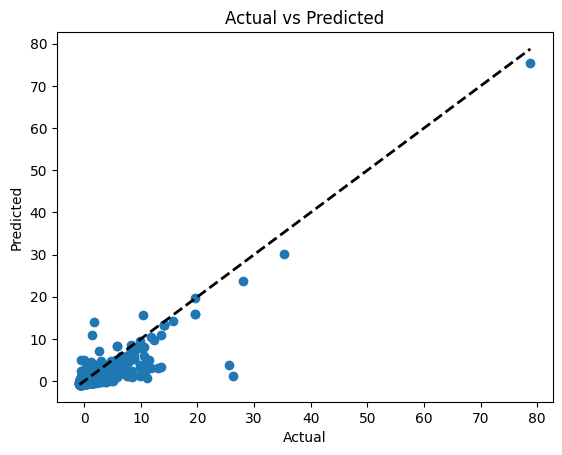

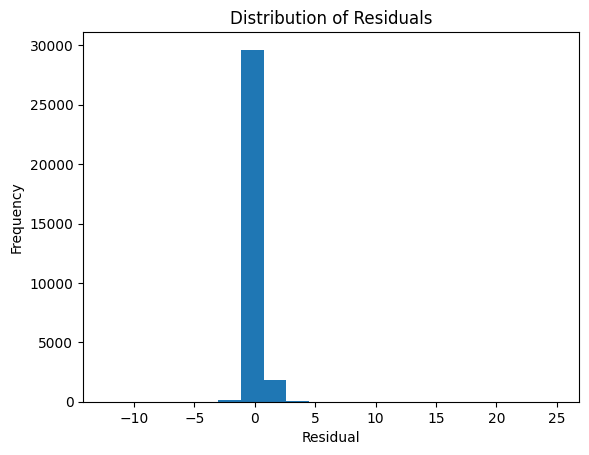

In [9]:
# Calculate metrics
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Adjusted R-squared: {adjusted_r2}")
print(f"Mean Absolute Percent Error (MAPE): {mape}%")

# Plotting Actual vs Predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # 45-degree line
plt.title('Actual vs Predicted')
plt.show()

# Histogram of Residuals
residuals = y_test - y_pred
plt.hist(residuals, bins=20)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

## Comments

<a id='comments'></a>

The adjusted R-squared of 0.40 means the model explains about 40% of the variability in the target variable, which is moderate. It's  lower than what I achieved with the Random Forest model (which was around 0.69). This suggests that the XGBoost model, in its current configuration, isn't capturing the underlying structure of the data as effectively as the Random Forest model did. Additionally, the MAPE of 334% is exceptionally high, indicating that, on average, the predictions are off by more than three times the actual values. This points to a significant level of inaccuracy in the model's predictions.

There are a number of steps that can be taken to potentially improve the results. These include:
- Hyper-parameter tuning through cross-validation and grid search or random search.
- Adjusting the learning rate and the depth of the trees to improve the model.
- Applying regularization to prevent overfitting.
- Revisit data preprocessing to ensure the handling of outliers, missing values, and feature scaling is appropriate.mance.a.